In [1]:
%pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Weights and Bias to version the dataset and experiment tracking
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")
import warnings
warnings.filterwarnings("ignore")

In [5]:
import json
import random

In [6]:
!pip install more-itertools

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [7]:
import collections
import itertools
from collections import Counter
from more_itertools import take

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam

from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support

In [8]:
SEED = 1234

In [9]:
def set_seeds(seed=1234):
    """set seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # For multi-gpu

In [10]:
set_seeds(SEED)

In [11]:
cuda = True
device = torch.device("cuda" if(
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")

if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

print(device)

cuda


In [12]:
train_df = pd.read_parquet("../../dataset/v2.0/train.parquet")
val_df = pd.read_parquet("../../dataset/v2.0/val.parquet")
test_df = pd.read_parquet("../../dataset/v2.0/test.parquet")

In [13]:
train_df.head()

,transcription,specialty
0,preoperative diagnosis recurrent vulvar melano...,surgery
1,preoperative diagnoses 1 left carpal tunnel sy...,orthopedic
2,preoperative diagnosis foreign body airway pos...,surgery
3,admission diagnoses 1 menometrorrhagia 2 dysme...,obstetrics / gynecology
4,reason consultation antibiotic management righ...,general medicine


[1480, 1239, 1239, 1159, 1159, 1139, 1136, 1030, 1003, 1003]


<AxesSubplot:ylabel='count'>

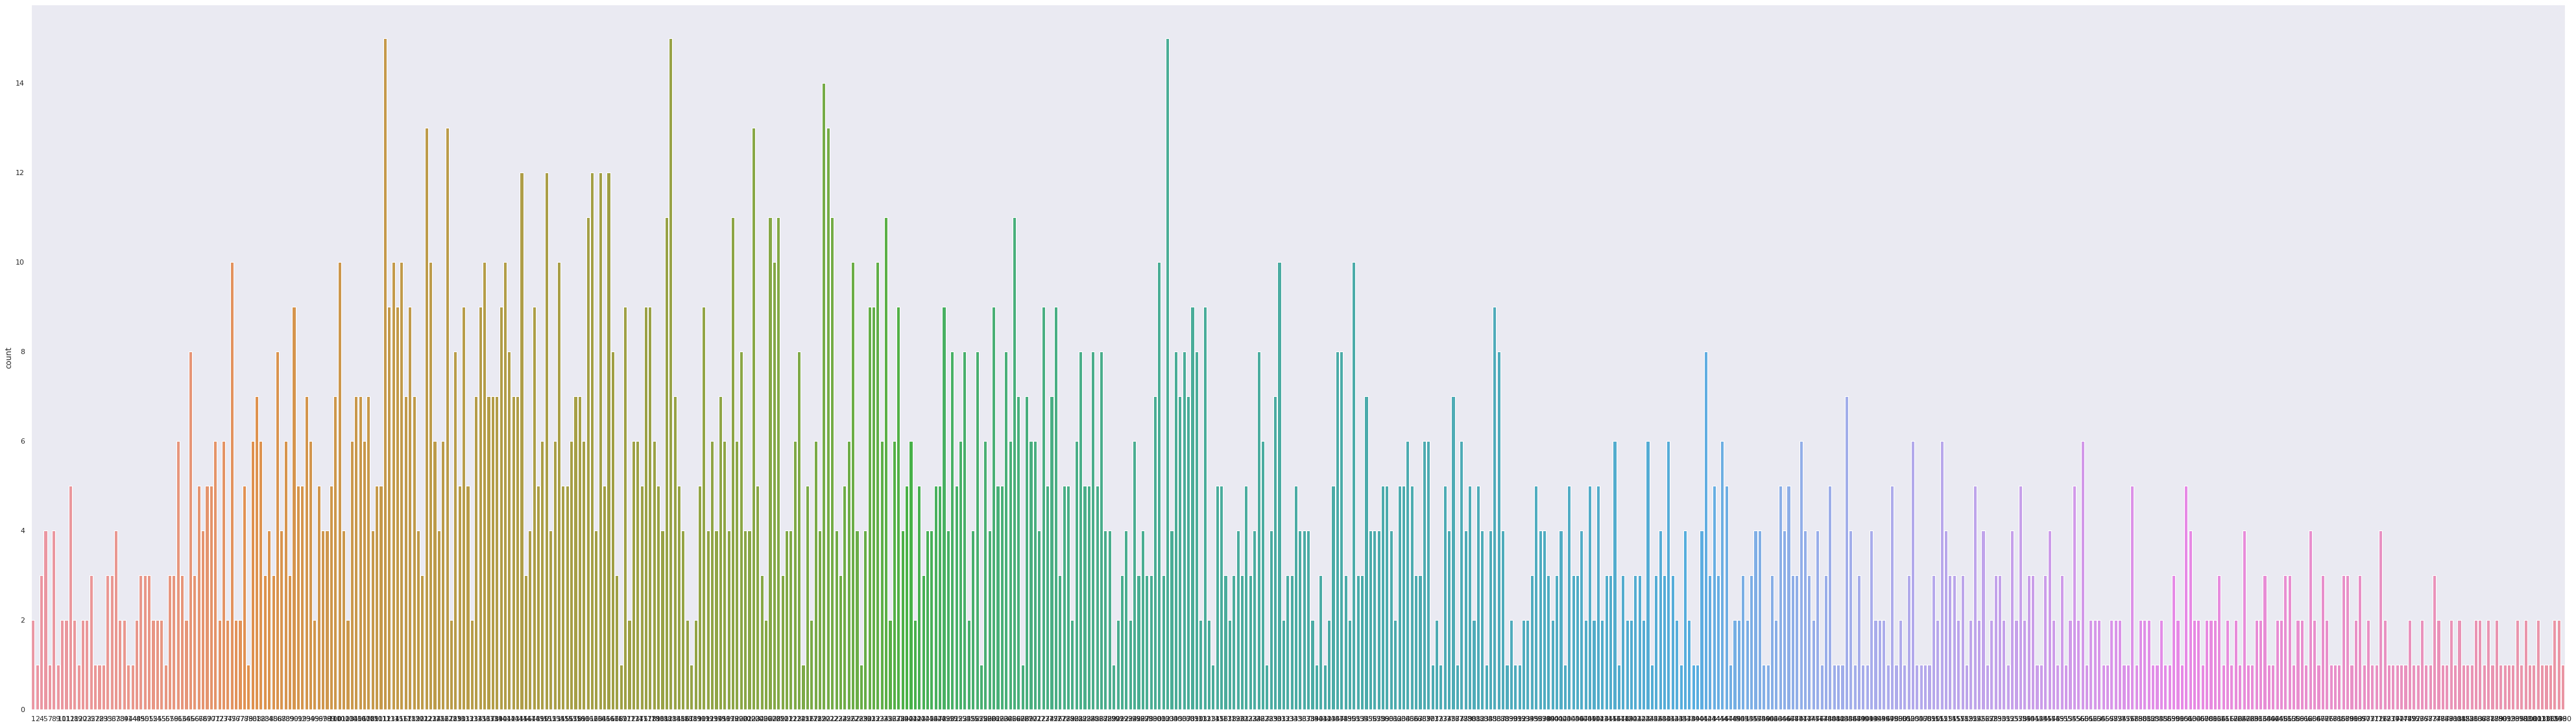

In [14]:
# Sentence length distribution
sent_lengths = sorted([len(sent.split(' ')) for sent in train_df['transcription'].values], reverse=True)
print(sent_lengths[:10])
plt.figure(figsize=(70,20))
sns.countplot(sent_lengths)

In [15]:
sent_counter = Counter(sent_lengths).most_common(1000)
sent_counter

[(303, 15),
 (183, 15),
 (112, 15),
 (220, 14),
 (221, 13),
 (203, 13),
 (127, 13),
 (122, 13),
 (166, 12),
 (164, 12),
 (162, 12),
 (151, 12),
 (145, 12),
 (266, 11),
 (235, 11),
 (222, 11),
 (209, 11),
 (207, 11),
 (198, 11),
 (182, 11),
 (161, 11),
 (351, 10),
 (331, 10),
 (301, 10),
 (233, 10),
 (227, 10),
 (208, 10),
 (154, 10),
 (141, 10),
 (136, 10),
 (123, 10),
 (116, 10),
 (114, 10),
 (101, 10),
 (75, 10),
 (386, 9),
 (312, 9),
 (309, 9),
 (276, 9),
 (273, 9),
 (261, 9),
 (249, 9),
 (238, 9),
 (232, 9),
 (231, 9),
 (191, 9),
 (178, 9),
 (177, 9),
 (171, 9),
 (148, 9),
 (140, 9),
 (135, 9),
 (131, 9),
 (118, 9),
 (115, 9),
 (113, 9),
 (90, 9),
 (442, 8),
 (387, 8),
 (348, 8),
 (347, 8),
 (326, 8),
 (310, 8),
 (307, 8),
 (305, 8),
 (287, 8),
 (285, 8),
 (282, 8),
 (264, 8),
 (257, 8),
 (254, 8),
 (251, 8),
 (214, 8),
 (200, 8),
 (167, 8),
 (142, 8),
 (129, 8),
 (86, 8),
 (65, 8),
 (485, 7),
 (376, 7),
 (355, 7),
 (330, 7),
 (308, 7),
 (306, 7),
 (300, 7),
 (275, 7),
 (269, 7),
 

In [16]:
# Feature and target
X_train = train_df.transcription.values
y_train = train_df.specialty

X_val =  val_df.transcription.values
y_val = val_df.specialty

X_test = test_df.transcription.values
y_test = test_df.specialty

In [18]:
print(f"X_train: {X_train.shape}, y_train:{y_train.shape}")
print(f"X_val: {X_val.shape}, y_val:{y_val.shape}")
print(f"X_test: {X_test.shape}, y_test:{y_test.shape}")

X_train: (2483,), y_train:(2483,)
X_val: (532,), y_val:(532,)
X_test: (533,), y_test:(533,)


In [19]:
print(f"Sample: {X_train[0]} -> {y_train[0]}")

Sample: preoperative diagnosis recurrent vulvar melanoma postoperative diagnosis recurrent vulvar melanoma operation performed radical anterior hemivulvectomy posterior skinning vulvectomy specimens radical anterior hemivulvectomy posterior skinning vulvectomy indications procedure patient history vulvar melanoma first diagnosed november 1995 surgical resection time recently noted recurrence irritated nodule around clitoris biopsy obtained patient confirmed recurrence addition biopsies posterior labia left side demonstrated melanoma situ findings examination anesthesia biopsy sites visible slightly pigmented irregular area epithelium seen near clitoris obvious lesions seen room darkened woods lamp used inspect epithelium marking pen used outline pigmented areas included several patches right left labia procedure patient prepped draped scalpel used incise skin anterior portion specimen radical anterior hemivulvectomy designed 1 5 2 0 cm margin would obtained depth carried fascia urogeni

In [20]:
# Label encoder to encode class labels
class LabelEncoder(object):
    """Encode labels into unqiue ids/integers"""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        
    def __len__(self):
        return len(self.class_to_index)
    
    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"
    
    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self
    
    def encode(self, y):
        encoded = np.zeros(len(y), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded
    
    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
            
        return classes
    
    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)
    
    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [22]:
label_encoder = LabelEncoder.load("../../data_artifacts/new_label_encoder.json")

In [23]:
# Encode all our labels
y_train = label_encoder.encode(y_train)

y_val = label_encoder.encode(y_val)

y_test = label_encoder.encode(y_test)

In [24]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print(f"counts: {counts}\n weights: {class_weights}")

counts: [260  67 157 181  63  57 156  66 109  58 248 191 761 109]
 weights: {0: 0.0038461538461538464, 1: 0.014925373134328358, 2: 0.006369426751592357, 3: 0.0055248618784530384, 4: 0.015873015873015872, 5: 0.017543859649122806, 6: 0.00641025641025641, 7: 0.015151515151515152, 8: 0.009174311926605505, 9: 0.017241379310344827, 10: 0.004032258064516129, 11: 0.005235602094240838, 12: 0.001314060446780552, 13: 0.009174311926605505}


In [25]:
# Tokenizer
class Tokenizer(object):
    def __init__(self, char_level, num_tokens=None, pad_token="<PAD>",
                oov_token="<UNK", token_to_index=None):
        self.char_level = char_level
        self.separator = "" if self.char_level else " "
        if num_tokens: num_tokens -=2 # pad token and unk token excluded
        self.num_tokens = num_tokens
        self.pad_token = pad_token
        self.oov_token = oov_token
        
        if not token_to_index:
            token_to_index = {pad_token: 0, oov_token: 1}
        self.token_to_index = token_to_index
        self.index_to_token = {v:k for k, v in self.token_to_index.items()}
        
    def __len__(self):
        return len(self.token_to_index)
    
    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"
    
    def fit_on_texts(self, texts):
        if not self.char_level:
            texts = [text.split(' ') for text in texts]
        all_tokens = [token for text in texts for token in text]
        counts = Counter(all_tokens).most_common(self.num_tokens)
        self.min_token_freq = counts[-1][1]
        
        for token, count in counts:
            index = len(self)
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return self
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            if not self.char_level:
                text = text.split(" ")
            sequence = []
            for token in text:
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]
                ))
            sequences.append(sequence)
        return sequences
            
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(
                    index, self.oov_token
                ))
            texts.append(self.separator.join([token for token in text]))
        return texts
    
    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {
                "char_level": self.char_level,
                "oov_token": self.oov_token,
                "token_to_index": self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
    
    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [26]:
# Check the full vocabulary size of training data
def check_vocab_size(texts):
    texts = [text.split(' ') for text in texts]
    all_tokens = [token for text in texts for token in text]
    # print(len(all_tokens))
    vocab_counts = Counter(all_tokens).most_common(None)
    # print(vocab_counts)
    print(f"Total vocabulary size is: {len(vocab_counts)}")

In [27]:
check_vocab_size(X_train)

Total vocabulary size is: 21506


In [28]:
tokenizer = Tokenizer(char_level=False, num_tokens=500)
tokenizer.fit_on_texts(texts=X_train)
VOCAB_SIZE = len(tokenizer)
print(tokenizer)

<Tokenizer(num_tokens=500)>


In [29]:
# Sample
print(take(15, tokenizer.token_to_index.items()))
print(f"Least frequent token's frequency: {tokenizer.min_token_freq}")

[('<PAD>', 0), ('<UNK', 1), ('patient', 2), ('right', 3), ('left', 4), ('procedure', 5), ('2', 6), ('placed', 7), ('1', 8), ('0', 9), ('3', 10), ('normal', 11), ('history', 12), ('well', 13), ('4', 14)]
Least frequent token's frequency: 275


In [30]:
tokenizer.save(Path("../../data_artifacts/new_tokenizer.json"))

In [31]:
# convert texts to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

preprocessed_text = tokenizer.sequences_to_texts([X_train[0]])[0]
print("Text to indices: \n"
     f" (Preprocessed) -> {preprocessed_text}\n"
     f" (Tokenized) -> {X_train[0]}")

Text to indices: 
 (Preprocessed) -> preoperative diagnosis <UNK <UNK <UNK postoperative diagnosis <UNK <UNK <UNK operation performed <UNK anterior <UNK posterior <UNK <UNK <UNK <UNK anterior <UNK posterior <UNK <UNK indications procedure patient history <UNK <UNK first <UNK <UNK <UNK surgical resection time <UNK noted <UNK <UNK <UNK around <UNK biopsy obtained patient confirmed <UNK <UNK <UNK posterior <UNK left side demonstrated <UNK <UNK findings examination anesthesia biopsy <UNK <UNK <UNK <UNK <UNK area <UNK seen <UNK <UNK <UNK lesions seen room <UNK <UNK <UNK used <UNK <UNK <UNK <UNK used <UNK <UNK areas <UNK several <UNK right left <UNK procedure patient prepped draped scalpel used <UNK skin anterior portion specimen <UNK anterior <UNK <UNK 1 5 2 0 cm <UNK would obtained <UNK carried fascia <UNK <UNK subcutaneous <UNK divided electrocautery specimen <UNK <UNK removal <UNK anterior portion skin posterior <UNK <UNK body <UNK skin incised scalpel electrocautery used <UNK removal sp

In [32]:
def to_categorical(seq, num_classes):
    """One-hot encode sequence of tokens"""
    one_hot = np.zeros((len(seq), num_classes))
    for i, item in enumerate(seq):
        one_hot[i, item] = 1
    return one_hot

In [33]:
print(X_train[0])
print(len(X_train[0]))
cat = to_categorical(seq=X_train[0], num_classes=len(tokenizer))
print(cat)
print(cat.shape)

[48, 26, 1, 1, 1, 44, 26, 1, 1, 1, 237, 18, 1, 28, 1, 49, 1, 1, 1, 1, 28, 1, 49, 1, 1, 243, 5, 2, 12, 1, 1, 141, 1, 1, 1, 137, 496, 27, 1, 23, 1, 1, 1, 285, 1, 235, 51, 2, 466, 1, 1, 1, 49, 1, 4, 65, 459, 1, 1, 73, 94, 17, 235, 1, 1, 1, 1, 1, 45, 1, 112, 1, 1, 1, 321, 112, 25, 1, 1, 1, 22, 1, 1, 1, 1, 22, 1, 1, 497, 1, 387, 1, 3, 4, 1, 5, 2, 61, 66, 474, 22, 1, 24, 28, 193, 408, 1, 28, 1, 1, 8, 15, 6, 9, 53, 1, 204, 51, 1, 178, 113, 1, 1, 136, 1, 403, 267, 408, 1, 1, 399, 1, 28, 193, 24, 49, 1, 1, 271, 1, 24, 460, 474, 267, 22, 1, 399, 408, 1, 43, 1, 136, 152, 1, 10, 9, 39, 52, 1, 404, 101, 1, 1, 388, 1, 5, 2, 31, 230, 17, 122, 1, 82, 70]
174
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(174, 500)


In [34]:
vocab_size = len(tokenizer)
X_train = [to_categorical(seq=seq, num_classes=vocab_size) for seq in X_train]
X_val = [to_categorical(seq=seq, num_classes=vocab_size) for seq in X_val]
X_test = [to_categorical(seq=seq, num_classes=vocab_size) for seq in X_test]

In [35]:
# Pad the sequences to max_length
def pad_sequences(sequences, max_seq_len=0):
    """Pad sequences to max_length in sequence"""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    num_classes = sequences[0].shape[-1]
    padded_sequences = np.zeros((len(sequences), max_seq_len, num_classes))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

In [36]:
print(X_train[0].shape, X_train[1].shape, X_train[2].shape)
padded = pad_sequences(X_train[0:3])
print(padded.shape)

(174, 500) (285, 500) (162, 500)
(3, 285, 500)


In [37]:
FILTER_SIZE = 1 # Unigram, we can try bigram and trigram as well

In [38]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, max_filter_size):
        self.X = X
        self.y = y
        self.max_filter_size = max_filter_size
        
    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, y]
    
    def collate_fn(self, batch):
        batch = np.array(batch)
        X = batch[:, 0]
        y = batch[:, 1]
        
        X = pad_sequences(X, max_seq_len=self.max_filter_size)
        
        X = torch.FloatTensor(X.astype(np.int32))
        y = torch.LongTensor(y.astype(np.int32))
        
        return X, y
    
    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle, drop_last=drop_last, pin_memory=True
        )

In [39]:
train_dataset = Dataset(X=X_train, y=y_train, max_filter_size=FILTER_SIZE)
val_dataset = Dataset(X=X_val, y=y_val, max_filter_size=FILTER_SIZE)
test_dataset = Dataset(X=X_test, y=y_test, max_filter_size=FILTER_SIZE)

In [40]:
print("Dasets: \n"
     f"Train Dataset: {train_dataset.__str__()}\n"
     f"Val Dataset: {val_dataset.__str__()}\n"
     f"Test Dataset: {test_dataset.__str__()}\n"
     f"Sample Data:\n"
     f"X: {train_dataset[0][0]}\n"
     f"y {train_dataset[0][1]}")

Dasets: 
Train Dataset: <Dataset(N=2483)>
Val Dataset: <Dataset(N=532)>
Test Dataset: <Dataset(N=533)>
Sample Data:
X: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
y 12


In [41]:
batch_size = 64
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)

In [42]:
batch_X, batch_y = next(iter(train_dataloader))
print("Sample batch:\n"
     f"X: {list(batch_X.size())}\n"
     f"y: {list(batch_y.size())}\n"
     f"Sample point: \n"
     f"X: {batch_X[0]}\n"
     f"y: {batch_y[0]}")

Sample batch:
X: [64, 1001, 500]
y: [64]
Sample point: 
X: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cpu')
y: 12


In [43]:
NUM_FILTERS = 50
HIDDEN_DIM = 128
DROPOUT_P = 0.1
NUM_CLASSES = len(label_encoder)

In [44]:
NUM_CLASSES

14

In [45]:
class CNN(nn.Module):
    def __init__(self, vocab_size, num_filters, filter_size,
                hidden_dim, dropout, num_classes):
        super(CNN, self).__init__()
        
        self.filter_size = filter_size
        self.conv = nn.Conv1d(
            in_channels=vocab_size, out_channels=num_filters,
            kernel_size=filter_size, stride=1, padding=0, padding_mode="zeros"
        )
        self.batch_norm = nn.BatchNorm1d(num_features=num_filters)
        
        self.fc1 = nn.Linear(num_filters, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, inputs, channel_first=False):
        x_in, = inputs
        if not channel_first:
            x_in = x_in.transpose(1, 2)
        
        # "SAME" padding
        max_seq_len = x_in.shape[2]
        padding_left = int((self.conv.stride[0]*(max_seq_len-1) - max_seq_len + self.filter_size)/2)
        padding_right = int(math.ceil((self.conv.stride[0]*(max_seq_len-1) - max_seq_len + self.filter_size)/2))
        
        z = self.conv(F.pad(x_in, (padding_left, padding_right)))
        z = F.max_pool1d(z, z.size(2)).squeeze(2)
        
        
        z = self.fc1(z)
        z = self.dropout(z)
        z = self.fc2(z)
        
        return z

In [46]:
model = CNN(vocab_size=VOCAB_SIZE, num_filters=NUM_FILTERS, filter_size=FILTER_SIZE,
            hidden_dim=HIDDEN_DIM, dropout=DROPOUT_P, num_classes=NUM_CLASSES)
model = model.to(device) # set device
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (conv): Conv1d(500, 50, kernel_size=(1,), stride=(1,))
  (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=14, bias=True)
)>


In [47]:
LEARNING_RATE = 1e-3
PATIENCE = 5
NUM_EPOCHS = 50

In [48]:
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    def train_step(self, dataloader):
        self.model.train()
        loss = 0.0
        
        # iterate over batches
        for i, batch in enumerate(dataloader):
            batch = [item.to(device) for item in batch]
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()
            z = self.model(inputs)
            J = self.loss_fn(z, targets)
            J.backward()
            self.optimizer.step()
            
            loss += (J.detach().item() - loss) / (i+1)
        return loss
    
    def eval_step(self, dataloader):
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []
        
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):
                batch = [item.to(device) for item in batch]
                inputs, y_true = batch[:-1], batch[-1]
                
                z = self.model(inputs)
                J = self.loss_fn(z, y_true).item()
                
                loss += (J - loss) / (i + 1)
                
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())
                
            
            return loss, np.vstack(y_trues), np.vstack(y_probs)
        
    def predict_step(self, dataloader):
        self.model.eval()
        y_probs = []
        
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):
                inputs, targets = batch[:-1], batch[-1]
                
                z = self.model(inputs)
                
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)
            return np.vstack(y_probs)
    
    def train(self, num_epochs, patience, train_dataloder, val_dataloader, wandb_run):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            print(f"[INFO] Epoch: {epoch+1} training started")
            train_loss = self.train_step(dataloader=train_dataloader)
            print(f"[INFO] Epoch: {epoch+1} training finished")
            print(f"[INFO] Epoch: {epoch+1} evaluation started")
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            print(f"[INFO] Epoch: {epoch+1} evaluation finished")
            self.scheduler.step(val_loss)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                wandb_run.summary["Best val loss"] = best_val_loss
                _patience = patience
            else:
                _patience -= 1
            
            if not _patience:
                print("Stopping Early")
                break
            print(f"[INFO] Logging wandb")
            wandb.log({"train_loss": train_loss})
            wandb.log({"val_loss": val_loss})
            
            print(
                f"Epoch: {epoch+1}\n"
                f"\t train_loss: {train_loss:.3f}, "
                f"\t val_loss: {val_loss: .3f}, "
                f"\t LR: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model

In [49]:
# loss function
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [50]:
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3
)

In [54]:
CONFIG = dict(
    learning_rate=LEARNING_RATE,
    patience=PATIENCE,
    epochs=NUM_EPOCHS,
    target_classes=NUM_CLASSES,
    optimizer="Adam",
    scheduler="ReduceLROnPlateau",
    loss_function="Cross Entropy",
    model="CNN",
)

In [52]:
import wandb

In [53]:
wandb.login()

wandb: Currently logged in as: alokpadhi. Use `wandb login --relogin` to force relogin


True

In [55]:
run = wandb.init(project="Medical-Transcription", config=CONFIG, name="CNN-new")

In [56]:
trainer = Trainer(model=model, device=device, loss_fn=loss_fn,
                 optimizer=optimizer, scheduler=scheduler)

In [57]:
best_model = trainer.train(
    NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader, run
)

[INFO] Epoch: 1 training started
[INFO] Epoch: 1 training finished
[INFO] Epoch: 1 evaluation started
[INFO] Epoch: 1 evaluation finished
[INFO] Logging wandb
Epoch: 1
	 train_loss: 2.641, 	 val_loss:  2.633, 	 LR: 1.00E-03, _patience: 5
[INFO] Epoch: 2 training started
[INFO] Epoch: 2 training finished
[INFO] Epoch: 2 evaluation started
[INFO] Epoch: 2 evaluation finished
[INFO] Logging wandb
Epoch: 2
	 train_loss: 2.625, 	 val_loss:  2.608, 	 LR: 1.00E-03, _patience: 5
[INFO] Epoch: 3 training started
[INFO] Epoch: 3 training finished
[INFO] Epoch: 3 evaluation started
[INFO] Epoch: 3 evaluation finished
[INFO] Logging wandb
Epoch: 3
	 train_loss: 2.561, 	 val_loss:  2.491, 	 LR: 1.00E-03, _patience: 5
[INFO] Epoch: 4 training started
[INFO] Epoch: 4 training finished
[INFO] Epoch: 4 evaluation started
[INFO] Epoch: 4 evaluation finished
[INFO] Logging wandb
Epoch: 4
	 train_loss: 2.397, 	 val_loss:  2.334, 	 LR: 1.00E-03, _patience: 5
[INFO] Epoch: 5 training started
[INFO] Epoch: 5

In [58]:
def get_metrics(y_true, y_pred, classes):
    performance = {"overall": {}, "class": {}}
    
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1-score"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))
    
    # Per-class performance
    class_metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": class_metrics[0][i],
            "recall": class_metrics[1][i],
            "f1-score": class_metrics[2][i],
            "num_samples": np.float64(class_metrics[3][i]),
        }
        
    return performance

In [59]:
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

In [60]:
performance = get_metrics(y_true, y_pred, classes=label_encoder.classes)
print(json.dumps(performance["overall"], indent=2))

{
  "precision": 0.40182806030992757,
  "recall": 0.399624765478424,
  "f1-score": 0.3676207804439093,
  "num_samples": 533.0
}


In [61]:
run.log({"precision": performance["overall"]["precision"], "recall": performance["overall"]["recall"], "f1-score": performance["overall"]["f1-score"]})